In [1]:
import json
import requests

First, we will set variables for the endpoints where we will retrieve the data

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Next we will set out parameters for aggregated legacy data and pagecount data

In [3]:
# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
params_pagecount_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "start" : "2007120100",
                "granularity" : "monthly",
                # for end use 1st day of month following final month of data
                 "end" : '2021100100'
                    }
params_pagecount_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : '2021100100'
                    }



# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021100100'
                        }
params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021100100'
                        }

params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021100100'
                        }


# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/mayapatward',
    'From': 'mp97@uw.edu'
}

This is our function for the api call that will return the response in json format

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

We will make api calls for each query type for both page count and page view data

In [5]:
monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
monthly_pageviews_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)
monthly_pageviews_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)

monthly_pagecount_mobile = api_call(endpoint_legacy, params_pagecount_mobile)
monthly_pagecount_desktop = api_call(endpoint_legacy, params_pagecount_desktop)

Next we will save this data to a local desktop file

In [6]:
with open('./Desktop/DATA512/pageviews_desktop_200712-202108.json', 'w') as outfile:
    json.dump(monthly_pageviews_desktop, outfile)
with open('./Desktop/DATA512/pageviews_mobile-web_200712-202108.json', 'w') as outfile:
    json.dump(monthly_pageviews_mobile_web, outfile)
with open('./Desktop/DATA512/pageviews_mobile-app_200712-202108.json', 'w') as outfile:
    json.dump(monthly_pageviews_mobile_app, outfile)
    
with open('./Desktop/DATA512/pagecounts_desktop-site_200712-202108.json', 'w') as outfile:
    json.dump(monthly_pagecount_desktop, outfile)
with open('./Desktop/DATA512/pagecounts_mobile-site_200712-202108.json', 'w') as outfile:
    json.dump(monthly_pagecount_mobile, outfile)

Several steps are taking place here, first, the json is being flattened into a pandas dataframe. Next, the columns timestamp and views/count are being selected. The views/count columns are then renamed to the appropriate name in order to indicate the source of the data and the query type. Finally, the timestamp is set as the index.

In [7]:
import pandas as pd    
df_pageviews_desktop = pd.json_normalize(monthly_pageviews_desktop['items'])[['timestamp', 'views']].rename(columns = {'views': 'pageviews_desktop_views'}).set_index('timestamp')
df_pageviews_mobile_web = pd.json_normalize(monthly_pageviews_mobile_web['items'])[['timestamp', 'views']].rename(columns = {'views': 'pageviews_mobile_web_views'}).set_index('timestamp')
df_pageviews_mobile_app = pd.json_normalize(monthly_pageviews_mobile_app['items'])[['timestamp', 'views']].rename(columns = {'views': 'pageviews_mobile_app_views'}).set_index('timestamp')
df_pagecount_mobile = pd.json_normalize(monthly_pagecount_mobile['items'])[['timestamp', 'count']].rename(columns = {'count': 'pagecount_mobile_views'}).set_index('timestamp')
df_pagecount_desktop = pd.json_normalize(monthly_pagecount_desktop['items'])[['timestamp', 'count']].rename(columns = {'count': 'pagecount_desktop_views'}).set_index('timestamp')


Here, we are joining all the dataframes created in order to create one large dataframe with the counts of all the query types from all the sources of data

In [13]:
df_all = df_pageviews_desktop.join(df_pageviews_mobile_web, how="outer").join(df_pageviews_mobile_app, how="outer").join(df_pagecount_mobile,how="outer").join(df_pagecount_desktop, how="outer")

Here we are filling all the NA values to 0

In [14]:
df_all_filled_na = df_all.fillna(0)

Our last preprocessing step is to combine the pageviews mobile and web and mobile app data, as well as create columns for all pageviews and all pagecounts. We are also creating a seperate column that identifies the year and month of the view. Finally we are dropping unnecessary columns

In [15]:
df_all_filled_na['pageviews_mobile_views'] = df_all_filled_na['pageviews_mobile_web_views'] + df_all_filled_na['pageviews_mobile_app_views']
df_all_filled_na['pageviews_all_views'] = df_all_filled_na['pageviews_mobile_views'] + df_all_filled_na['pageviews_desktop_views']
df_all_filled_na['pagecount_all_views'] = df_all_filled_na['pagecount_mobile_views'] + df_all_filled_na['pagecount_desktop_views']
df_all_filled_na['year'] = df_all_filled_na.index.str[:4]
df_all_filled_na['month'] = df_all_filled_na.index.str[4:6]
df_final = df_all_filled_na.drop(['pageviews_mobile_web_views', 'pageviews_mobile_app_views'], axis = 1)


We are saving to csv

In [16]:
df_final.to_csv('./Desktop/DATA512/en-wikipedia_traffic_200712-202108.csv')

In [17]:
df_final

,pageviews_desktop_views,pagecount_mobile_views,pagecount_desktop_views,pageviews_mobile_views,pageviews_all_views,pagecount_all_views,year,month
timestamp,,,,,,,,
2007120100,0.000000e+00,0.0,2.998332e+09,0.000000e+00,0.000000e+00,2.998332e+09,2007,12
2008010100,0.000000e+00,0.0,4.930903e+09,0.000000e+00,0.000000e+00,4.930903e+09,2008,01
2008020100,0.000000e+00,0.0,4.818394e+09,0.000000e+00,0.000000e+00,4.818394e+09,2008,02
2008030100,0.000000e+00,0.0,4.955406e+09,0.000000e+00,0.000000e+00,4.955406e+09,2008,03
2008040100,0.000000e+00,0.0,5.159162e+09,0.000000e+00,0.000000e+00,5.159162e+09,2008,04
...,...,...,...,...,...,...,...,...
2021050100,2.824416e+09,0.0,0.000000e+00,4.976580e+09,7.800996e+09,0.000000e+00,2021,05
2021060100,2.505971e+09,0.0,0.000000e+00,4.584510e+09,7.090482e+09,0.000000e+00,2021,06
2021070100,2.765584e+09,0.0,0.000000e+00,4.778909e+09,7.544494e+09,0.000000e+00,2021,07


Next we are plotting the data

Text(0.5, 1.0, 'Page Views On English Wikipedia')

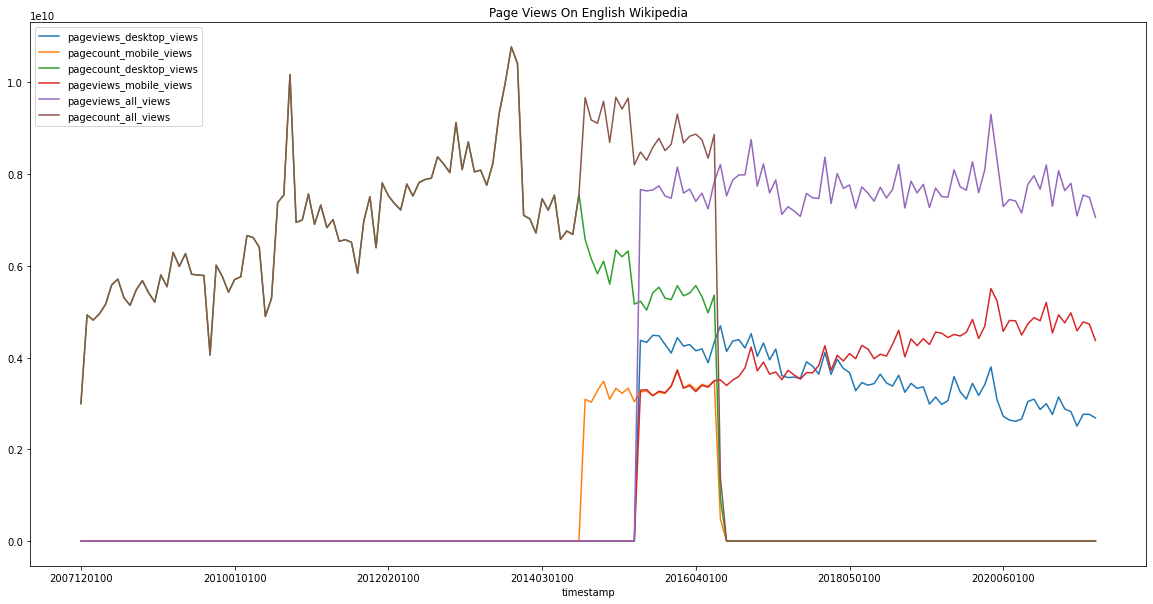

In [24]:
import matplotlib.pyplot as plt
df_final.plot(figsize = (20,10))
plt.title("Page Views On English Wikipedia")
